# 0. Importaciones

In [1]:
import os

import warnings
warnings.filterwarnings('ignore')

import joblib

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_auc_score, confusion_matrix, roc_curve

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from statsmodels.stats.diagnostic import normal_ad
from statsmodels.stats.diagnostic import acorr_ljungbox

from xgboost import XGBClassifier

from statsmodels.stats.outliers_influence import variance_inflation_factor

# 1. Satiscaccion clientes

In [ ]:
df = pd.read_csv("train.csv")
dfTest = pd.read_csv('test.csv')

## 1.1. EDA

In [ ]:
df['TARGET'].unique()

In [ ]:
df.describe()

In [ ]:
df.info()

In [ ]:
df.isnull().sum() #No hay datos faltantes

In [ ]:
bars = df['TARGET'].value_counts().plot(kind='bar',)
plt.title("Distribución de la variable target")
for i, count in enumerate(df['TARGET'].value_counts()):
    bars.text(i, count + 0.05, str(count), ha='center', va='bottom')
plt.show()

In [ ]:
variables_seleccionadas = df.select_dtypes(include=[np.number]).columns[1:11]  # Seleccionar 10 variables numéricas
df_ = df[variables_seleccionadas]
df_.hist(bins=15, figsize=(15, 10))
plt.show()

In [ ]:
for column in variables_seleccionadas:
    sns.boxplot(data=df_, x=column)
    plt.title(f"Boxplot: {column}")
    plt.show()

In [ ]:
# lleva mucho tiempo
for i, column_x in enumerate(variables_seleccionadas[:5]):
    for j, column_y in enumerate(variables_seleccionadas[5:10]):
        sns.scatterplot(data=df_, x=column_x, y=column_y)
        sns.regplot(data=df_, x=column_x, y=column_y, scatter_kws={'s':10})
        plt.title(f"{column_x} --- {column_y}")
        plt.show()

In [ ]:
imputer = IterativeImputer()
df[variables_seleccionadas] = imputer.fit_transform(df[variables_seleccionadas])

In [ ]:
def calcular_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(len(dataframe.columns))]
    return vif_data

# Iterar eliminación de variables con VIF >= 10
while True:
    vif_data = calcular_vif(df[variables_seleccionadas])
    max_vif = vif_data["VIF"].max()
    if max_vif >= 10:
        feature_to_remove = vif_data.loc[vif_data["VIF"].idxmax(), "feature"]
        variables_seleccionadas = variables_seleccionadas.drop(feature_to_remove)
    else:
        break

## 1.2. Entrenamiento y métricas

In [ ]:
# Separación de datos en entrenamiento y prueba
X = df[df.columns[:-1]]
Y = df['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# Escalamiento de datos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
modelos = {
    "Clasificasión Bayesiana": GaussianNB(),
    "K-NN": KNeighborsClassifier(),
    "L1-L2 Penalty Logistic Regression": LogisticRegression(penalty='l2', solver='liblinear'),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "SVM": SVC(probability=True)
}

In [ ]:
resultados = []

cont=0

for nombre, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    joblib.dump(modelo, f'modeloP1-{nombre}.pkl')

    y_pred = modelo.predict(X_test)
    y_prob = modelo.predict_proba(X_test)[:, 1]
    
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    
    resultados.append({
        "Modelo": nombre,
        "Precision": precision,
        "Recall": recall,
        "Accuracy": accuracy,
        "F1-Score": f1,
        "AUC": auc
    })

    cont=cont+1
    print(f'modelo {i}/6')

In [ ]:
tabla_resultados = pd.DataFrame(resultados)
tabla_resultados

## 1.3. prediccion CSV de prueba

In [ ]:
nombreModelos = ["Clasificasión Bayesiana","K-NN","L1-L2 Penalty Logistic Regression","Random Forest","XGBoost","SVM"]
dfPredicciones = pd.DataFrame()

for nombre in nombreModelos:
    modelo = joblib.load(f'modeloP1-{nombre}.pkl')
    prediccion = pd.Series(modelo.predict(dfTest.values))
    dfPredicciones[nombre] = prediccion

    bars = prediccion.value_counts().plot(kind='bar',)
    plt.title(f'Distribución predicciones {nombre}')
    for i, count in enumerate(prediccion.value_counts()):
        bars.text(i, count + 0.05, str(count), ha='center', va='bottom')
    plt.show()

joblib.dump(dfPredicciones, f'P1-resultados.pkl')

In [ ]:
modelo = joblib.load(f'modeloP1-{nombre}.pkl')

In [ ]:
dfPredicciones

# 2. Fisioterapia

## 2.1. Carga

In [2]:
carpeta = 'fisioterapia_dataset_regresion'
subjets = ['s1', 's2', 's3', 's4', 's5']
exercises = ['e1', 'e2', 'e3', 'e4', 'e5', 'e6', 'e7', 'e8']
units = ['u1', 'u2', 'u3', 'u4', 'u5']
nameTrain = 'template_session.txt'
nameTest = 'test.txt'

In [3]:
dataframesEntrenamiento = []
dataframesPruebas = []

for subjet in subjets:
    for exercise in exercises:
        for unit in units:
            rutaTrain = os.path.join(carpeta, subjet, exercise, unit, nameTrain)
            rutaTest = os.path.join(carpeta, subjet, exercise, unit, nameTest)
            dataframesEntrenamiento.append(pd.read_csv(rutaTrain, sep=';'))
            dataframesPruebas.append(pd.read_csv(rutaTest, sep=';'))

In [ ]:
dataframesEntrenamiento[0]

,time index,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,mag_x,mag_y,mag_z
0,1,-9.665799,-1.677241,0.615063,-0.014956,0.004388,0.010589,0.587318,0.455106,-0.094949
1,2,-9.665806,-1.684737,0.622513,0.000607,-0.003094,-0.007589,0.587428,0.455621,-0.093364
2,3,-9.628410,-1.699724,0.585751,0.006007,0.000557,-0.004879,0.588389,0.454722,-0.094907
3,4,-9.628372,-1.684836,0.600733,-0.003085,-0.000281,-0.000340,0.588673,0.455759,-0.092664
4,5,-9.643291,-1.639893,0.585661,-0.002932,-0.006807,-0.013043,0.589193,0.453927,-0.093143
...,...,...,...,...,...,...,...,...,...,...
2182,2183,-9.682711,-1.706522,0.350804,-0.005728,-0.003561,-0.001633,0.588366,0.459061,-0.064641
2183,2184,-9.667724,-1.691574,0.328685,-0.012997,0.010897,0.005710,0.587457,0.460252,-0.065893
2184,2185,-9.667731,-1.684025,0.306292,-0.020050,-0.000178,-0.008818,0.587153,0.456937,-0.065174
2185,2186,-9.667744,-1.699018,0.321194,-0.011103,0.007172,-0.001555,0.586819,0.457718,-0.064133


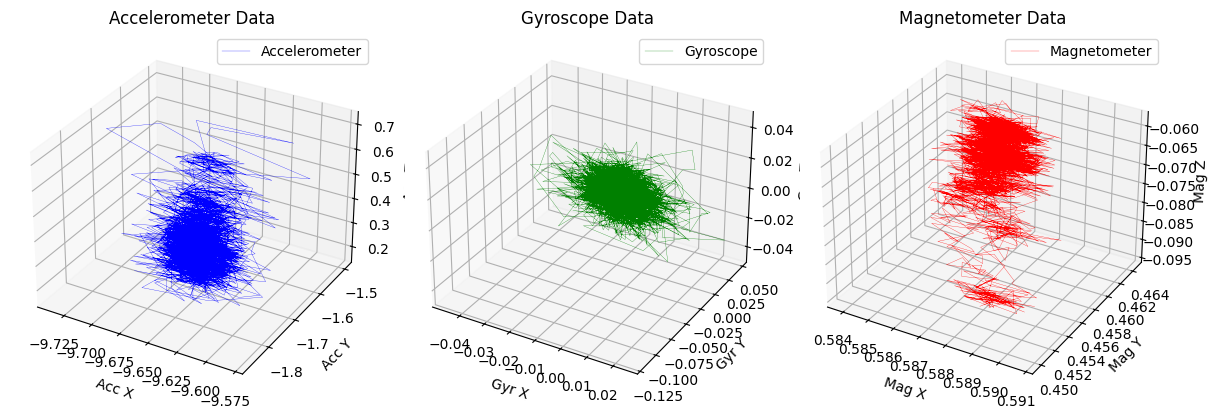

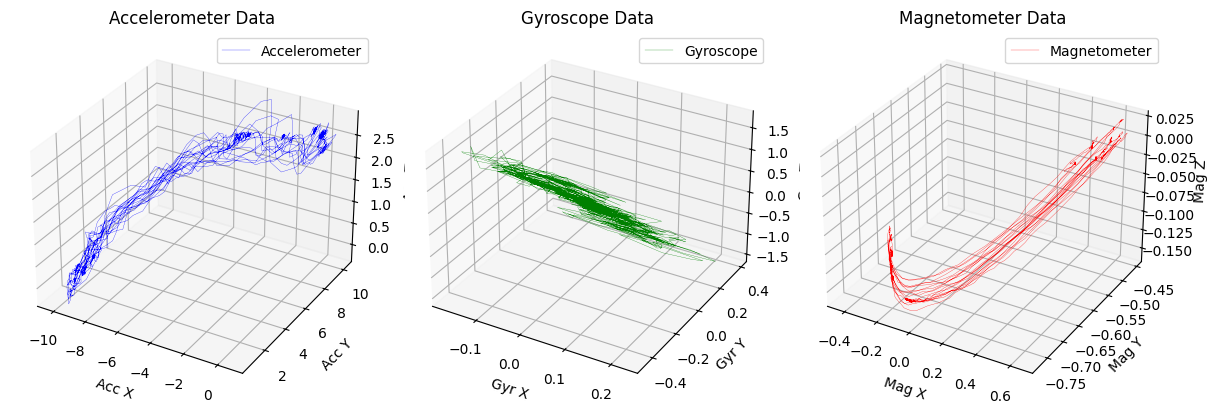

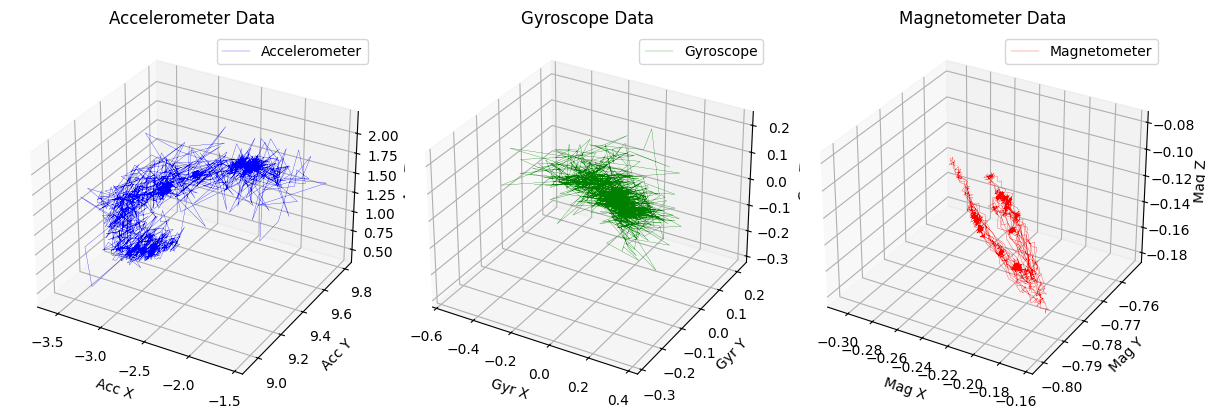

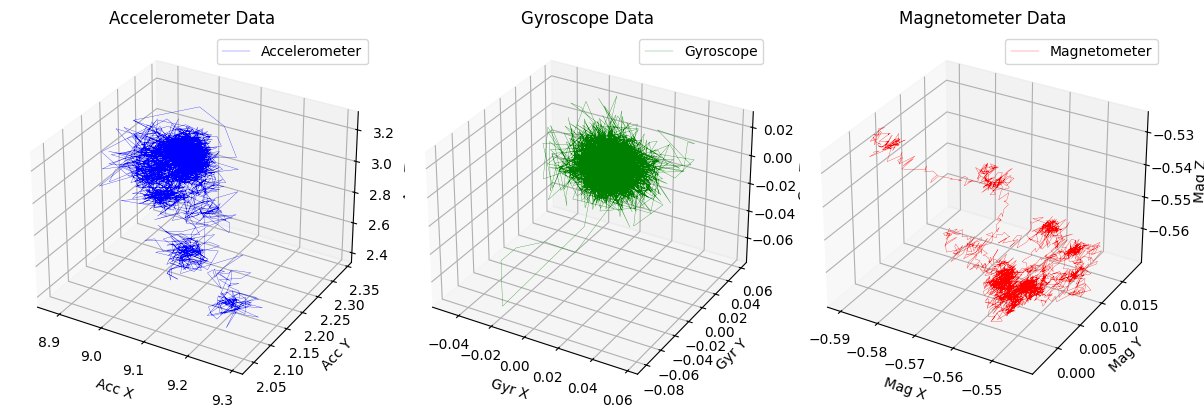

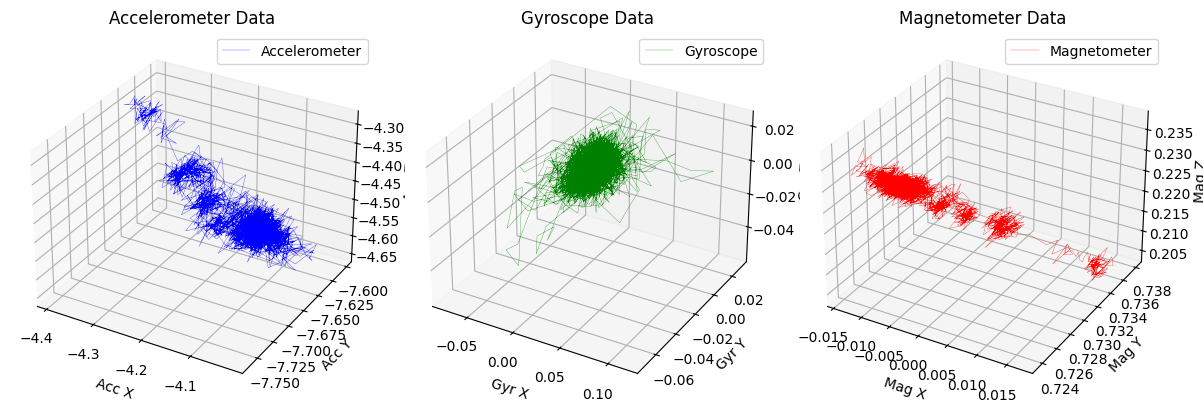

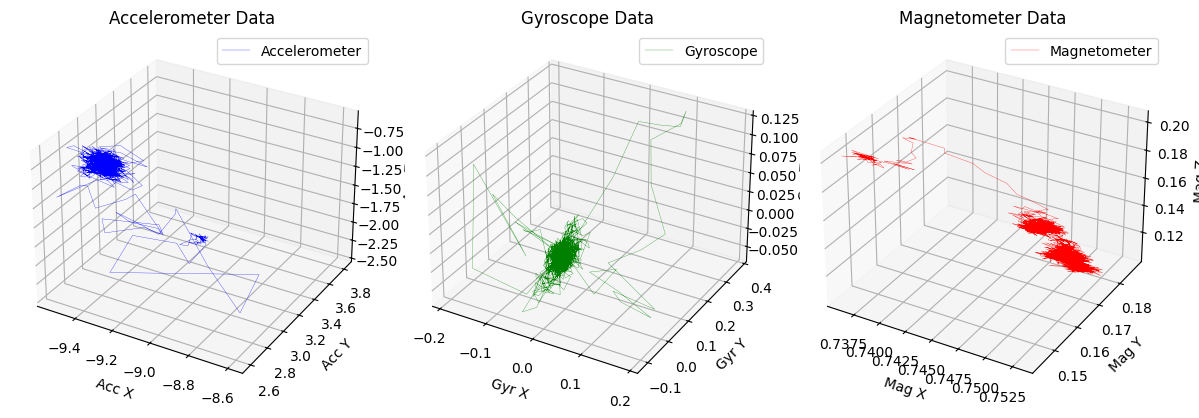

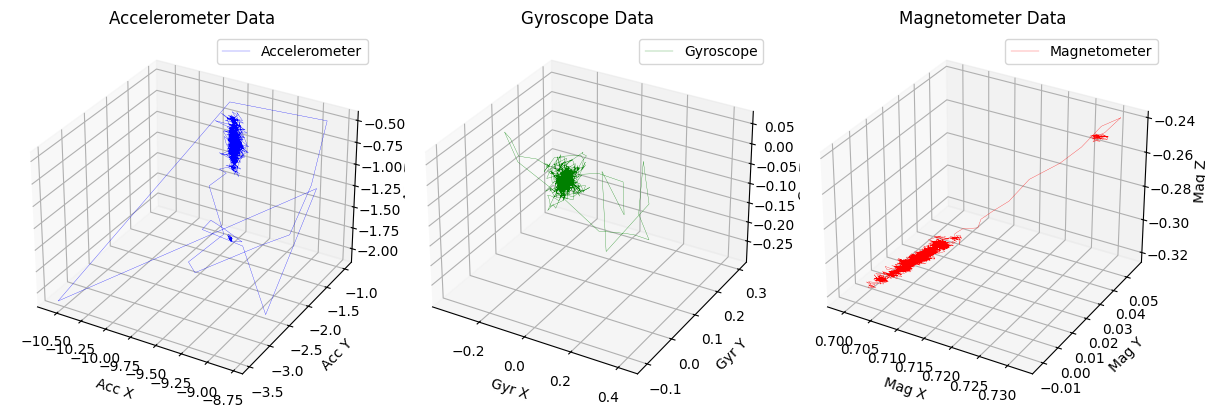

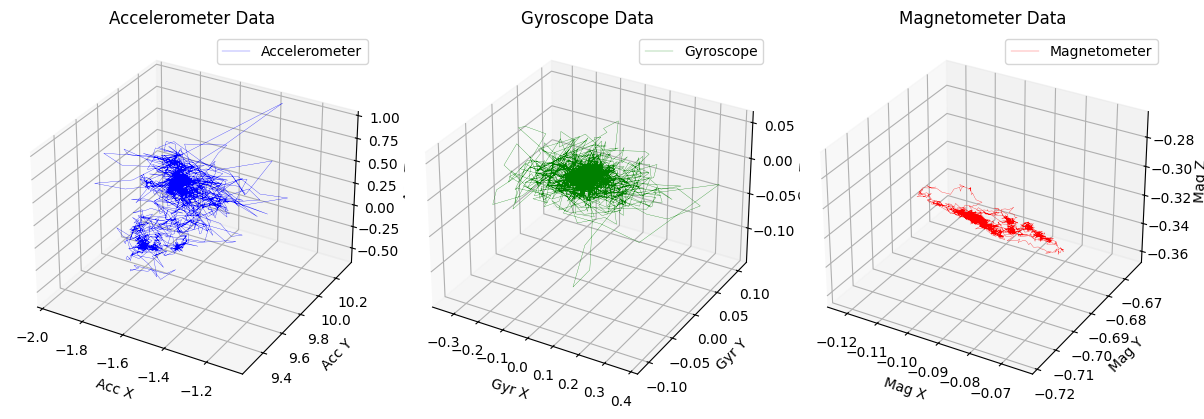

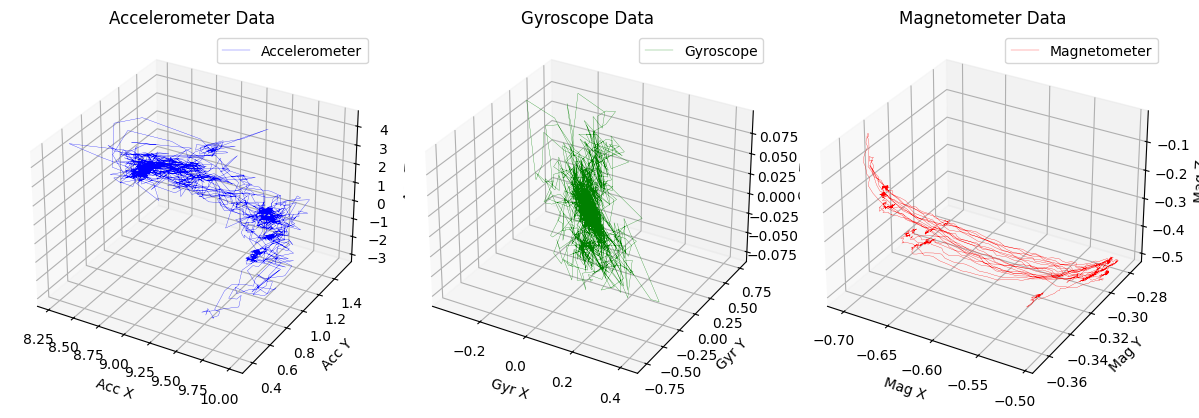

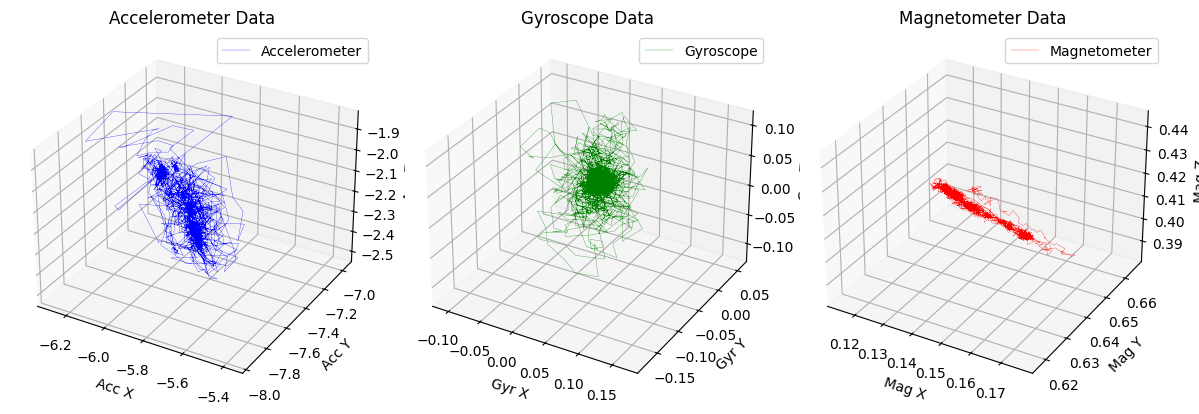

In [5]:
for indi in range(10):
    fig = plt.figure(figsize=(12,4))

    ax1 = fig.add_subplot(131, projection='3d')
    ax1.plot(dataframesEntrenamiento[indi]['acc_x'], dataframesEntrenamiento[indi]['acc_y'], dataframesEntrenamiento[indi]['acc_z'], label='Accelerometer', color='blue', linewidth=0.2)
    ax1.set_xlabel('Acc X')
    ax1.set_ylabel('Acc Y')
    ax1.set_zlabel('Acc Z')
    ax1.set_title('Accelerometer Data')
    ax1.legend()

    ax2 = fig.add_subplot(132, projection='3d')
    ax2.plot(dataframesEntrenamiento[indi]['gyr_x'], dataframesEntrenamiento[indi]['gyr_y'], dataframesEntrenamiento[indi]['gyr_z'], label='Gyroscope', color='green', linewidth=0.2)
    ax2.set_xlabel('Gyr X')
    ax2.set_ylabel('Gyr Y')
    ax2.set_zlabel('Gyr Z')
    ax2.set_title('Gyroscope Data')
    ax2.legend()

    ax3 = fig.add_subplot(133, projection='3d')
    ax3.plot(dataframesEntrenamiento[indi]['mag_x'], dataframesEntrenamiento[indi]['mag_y'], dataframesEntrenamiento[indi]['mag_z'], label='Magnetometer', color='red', linewidth=0.2)
    ax3.set_xlabel('Mag X')
    ax3.set_ylabel('Mag Y')
    ax3.set_zlabel('Mag Z')
    ax3.set_title('Magnetometer Data')
    ax3.legend()

    plt.tight_layout()
    plt.show()


## 2.2. Particiones

In [ ]:
def ParticionTrainValTest(df, horizonte, ventana):

    tamTrain = 14
    tamValid = 7
    tamTest = 7
    lendf = len(df)
    Train = []
    Validation = []
    Test = []
    cont = 0

    for index in range(0 ,  lendf-ventana-horizonte ):
        
        end = index+ventana

        if end+horizonte > lendf:
            break

        if cont > tamTrain+tamValid+tamTest:
            cont=0

        if cont < tamTrain:
            X_train = df.iloc[index : end]
            y_train = df.iloc[end : end+horizonte]
            Train.append({
                "X_train": X_train,
                "y_train": y_train
            })
        else:
            if cont < tamTrain+tamValid:
                X_val = df.iloc[index : end]
                y_val = df.iloc[end : end+horizonte]
                Validation.append({
                    "X_test": X_val,
                    "y_test": y_val
                })
            else:
                if cont < tamTrain+tamValid+tamTest:
                    X_test = df.iloc[index : end]
                    y_test = df.iloc[end : end+horizonte]
                    Test.append({
                        "X_test": X_test,
                        "y_test": y_test
                    })
        
        cont += 1


    return Train , Validation , Test

## 2.3. Entrenamiento y métricas

In [35]:
modelos = {
    "K-NN": KNeighborsRegressor(n_neighbors=3),
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Random Forest Regressor": RandomForestRegressor(n_estimators=100, random_state=0),
    "XGBoost Regressor": XGBRegressor(n_estimators=100, random_state=0),
    "SVR": SVR(kernel='rbf')
}

In [ ]:
def metricas(y_true, y_pred):
    mape = mean_absolute_percentage_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return {"MAPE": mape, "RMSE": rmse, "R2": r2}

def residuales(residuals):
    results = {
        "Ljung-Box": acorr_ljungbox(residuals, lags=[10])[1][0],
        "Jarque-Bera": normal_ad(residuals)[1]
    }
    return results

In [ ]:
horizontes = [7,14,21,28]
ventanas = [7,14,21,28]
results = []

for archivo in dataframesEntrenamiento:
    for ventana in ventanas:
        entrenamientos, validacions, pruebas = ParticionTrainValTest(archivo, horizontes[0], ventana)
        
        for entrenamiento in entrenamientos:
            X_train = entrenamiento['X_train']
            y_train = entrenamiento['y_train']

            X_test = pruebas['X_test']
            y_test = pruebas['y_test']
            
            for nombre, modelo in modelos.items():

                modelo.fit(X_train, y_train)

                y_pred = modelo.predict(X_test)

                residuals = y_test - y_pred
                metrics_results = metricas()
                residual_results = residuales(residuals)

                results.append({
                    "Modelo": nombre,
                    "τ": ventana,
                    "MAPE": metrics_results["MAPE"],
                    "RMSE": metrics_results["RMSE"],
                    "R²": metrics_results["R²"],
                    "Ljung-Box p-value": residual_results["Ljung-Box p-value"],
                    "Jarque-Bera p-value": residual_results["Jarque-Bera p-value"]
                })

                break
            break
        break
    break

X_train

TypeError: list indices must be integers or slices, not str

In [ ]:
tau_values = [7, 14, 21, 28]
results = []

# Entrenamiento y evaluación para cada modelo y cada horizonte temporal
for tau in tau_values:
    train, validation, test = ParticionTrainValTest(data['magnetic_field'], tau)
    
    for model_name, model in models.items():
        # Ajuste del modelo
        model.fit(np.arange(len(train)).reshape(-1, 1), train)
        
        # Predicciones en conjunto de validación y prueba
        val_predictions = model.predict(np.arange(len(train), len(train) + len(validation)).reshape(-1, 1))
        test_predictions = model.predict(np.arange(len(train) + len(validation), len(train) + len(validation) + len(test)).reshape(-1, 1))
        
        # Cálculo de métricas para validación y prueba
        val_metrics = calculate_metrics(validation, val_predictions)
        test_metrics = calculate_metrics(test, test_predictions)
        
        # Análisis de residuos
        residuals = test - test_predictions
        residual_results = residual_analysis(residuals)
        
        # Guardar resultados
        results.append({
            "Modelo": model_name,
            "τ": tau,
            "MAPE": test_metrics["MAPE"],
            "RMSE": test_metrics["RMSE"],
            "R²": test_metrics["R²"],
            "Ljung-Box p-value": residual_results["Ljung-Box p-value"],
            "Jarque-Bera p-value": residual_results["Jarque-Bera p-value"]
        })